In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from category_encoders import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown, Layout
import warnings

In [3]:
def wrangle(filepath):
    df= pd.read_csv(filepath, index_col="car_ID")
    
    #Drop Multicollinearity Columns
    df.drop(
        columns=["highwaympg", "horsepower", "curbweight", "carwidth", "compressionratio", "peakrpm",
                 "wheelbase", "carlength", "symboling", "boreratio", "citympg"], 
        inplace=True)
    
    #Get Car Company Names Only
    df["CarName"] = df["CarName"].str.split(" ", expand=True)[0]
    
    #Correct Car Names
    df["CarName"]=df["CarName"].str.replace("nissan", "Nissan", regex=False
                          ).replace("toyouta", "toyota", regex=False
                                    ).replace("porcshce", "porsche", regex=False
                                              ).replace("vw", "volkswagen", regex=False
                                                        ).replace("maxda", "mazda", regex=False)
    
    #Remove Categorical columns that don't generalize
    df.drop(columns=["enginelocation"], inplace=True)

    #Drop observations with only few data points
    df= df.drop(df[df["fuelsystem"]=="mfi"].index)
    df= df.drop(df[df["fuelsystem"]=="spfi"].index)
    
    return df

In [4]:
df = wrangle("ML practice CSVs/CarPrice_Assignment.csv")
df.head()

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,carheight,enginetype,cylindernumber,enginesize,fuelsystem,stroke,price
car_ID,,,,,,,,,,,,,
1,alfa-romero,gas,std,two,convertible,rwd,48.8,dohc,four,130,mpfi,2.68,13495.0
2,alfa-romero,gas,std,two,convertible,rwd,48.8,dohc,four,130,mpfi,2.68,16500.0
3,alfa-romero,gas,std,two,hatchback,rwd,52.4,ohcv,six,152,mpfi,3.47,16500.0
4,audi,gas,std,four,sedan,fwd,54.3,ohc,four,109,mpfi,3.40,13950.0
5,audi,gas,std,four,sedan,4wd,54.3,ohc,five,136,mpfi,3.40,17450.0


In [5]:
corr_table= df.select_dtypes("number").drop(columns="price").corr()
corr_table

,carheight,enginesize,stroke
carheight,1.000000,0.071858,-0.04178
enginesize,0.071858,1.000000,0.19832
stroke,-0.041780,0.198320,1.00000


<Axes: >

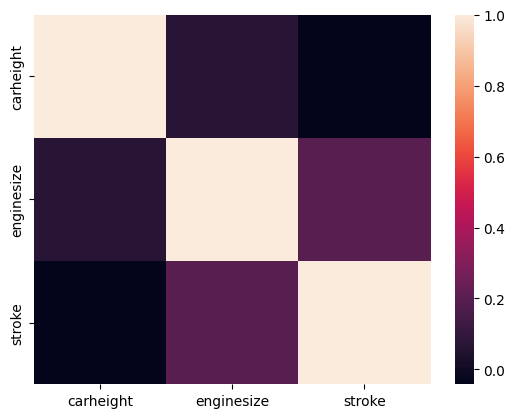

In [6]:
sns.heatmap(corr_table)

In [7]:
df.select_dtypes("object").nunique()

CarName           23
fueltype           2
aspiration         2
doornumber         2
carbody            5
drivewheel         3
enginetype         7
cylindernumber     7
fuelsystem         6
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

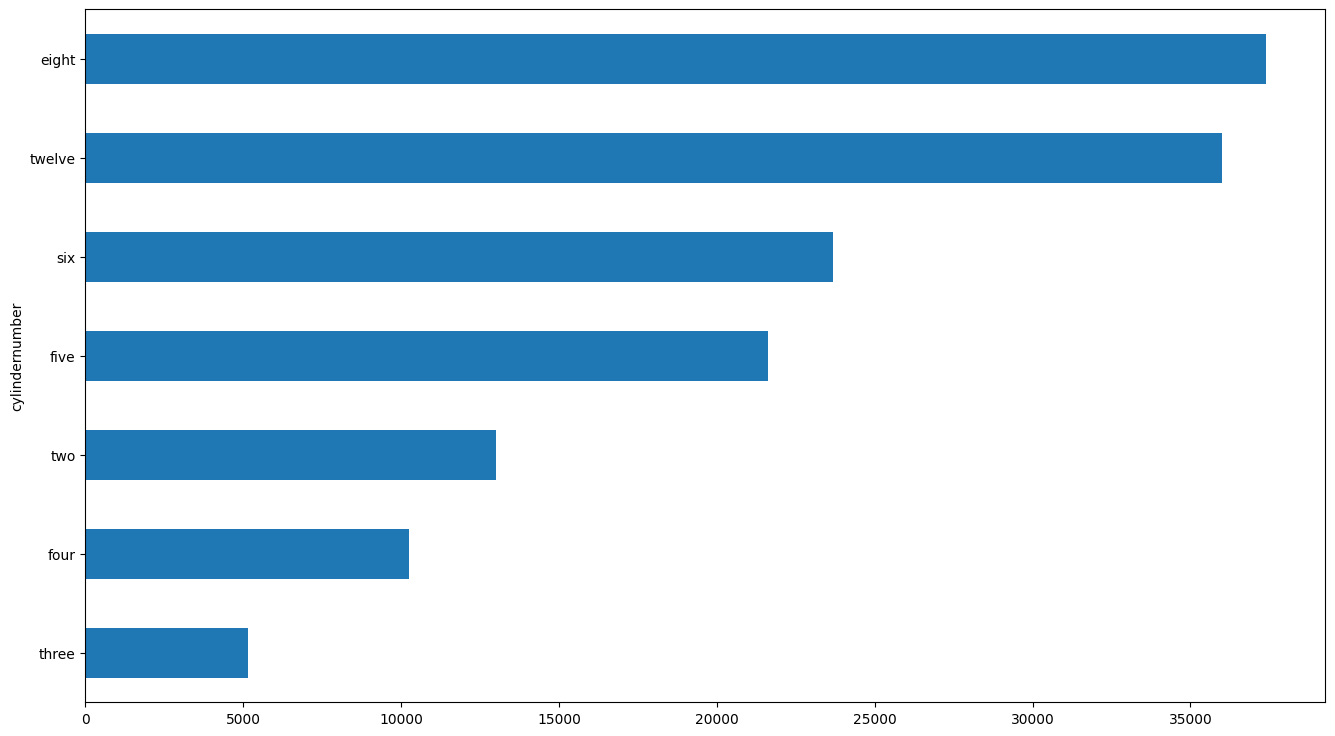

In [8]:
plt.figure(figsize=(16,9))
df.groupby("cylindernumber")["price"].mean().sort_values().plot(kind="barh")
plt.show

SPLIT DATA


X AND y SPLIT

In [9]:
target = "price"
X= df.drop(columns=target)
y= df[target]

print("X:", X.shape)
print("y:", y.shape)

X: (203, 12)
y: (203,)


In [10]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (162, 12)
X_test shape: (41, 12)
y_train shape: (162,)
y_test shape: (41,)


BUILD MODEL

        BASELINE

In [11]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
mae_baseline= mean_absolute_error(y_train, y_pred_baseline)


print("Mean Price:", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Price: 12410.07
Baseline MAE: 5165.62


        ITERATE

In [12]:
model= make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['CarName', 'fueltype', 'aspiration',
                                     'doornumber', 'carbody', 'drivewheel',
                                     'enginetype', 'cylindernumber',
                                     'fuelsystem'],
                               use_cat_names=True)),
                ('ridge', Ridge())])

        EVALUATE

In [13]:
mae_training= mean_absolute_error(y_train, model.predict(X_train))
mae_test = mean_absolute_error(y_test, model.predict(X_test))

print("Training MAE:", round(mae_training, 2))
print("Testing MAE:", round(mae_test, 2))

Training MAE: 1232.97
Testing MAE: 2047.73


COMMUNICATE

In [14]:
#Extract intercept and Coefficients
intercept= model.named_steps["ridge"].intercept_
coefficients= model.named_steps["ridge"].coef_
print("intercept:", round(intercept, 2))
print("coeficients:", coefficients[:5])

intercept: 4838.7
coeficients: [ -167.40927679 -1562.57684333  1110.1978465  -1344.37833673
  -471.10209065]


In [15]:
#Get features name
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("feature names:", feature_names[:20])

feature names: ['CarName_volvo' 'CarName_Nissan' 'CarName_honda' 'CarName_dodge'
 'CarName_peugeot' 'CarName_chevrolet' 'CarName_mazda' 'CarName_toyota'
 'CarName_audi' 'CarName_renault' 'CarName_plymouth' 'CarName_subaru'
 'CarName_volkswagen' 'CarName_mercury' 'CarName_bmw' 'CarName_isuzu'
 'CarName_mitsubishi' 'CarName_saab' 'CarName_alfa-romero'
 'CarName_jaguar']


C:\Users\EMMANUEL MEJEH\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\category_encoders\utils.py:366: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


In [16]:
#Features-Importance Series 
feat_imp = pd.Series(coefficients, index= feature_names)
feat_imp.head()

CarName_volvo      -167.409277
CarName_Nissan    -1562.576843
CarName_honda      1110.197846
CarName_dodge     -1344.378337
CarName_peugeot    -471.102091
dtype: float64

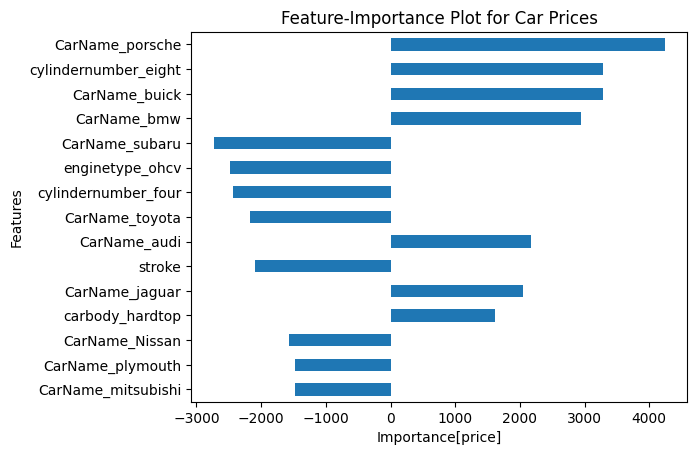

In [17]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance[price]")
plt.ylabel("Features")
plt.title("Feature-Importance Plot for Car Prices");


In [18]:
X.info()
X["enginesize"].unique()[:5]


<class 'pandas.core.frame.DataFrame'>
Index: 203 entries, 1 to 205
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CarName         203 non-null    object 
 1   fueltype        203 non-null    object 
 2   aspiration      203 non-null    object 
 3   doornumber      203 non-null    object 
 4   carbody         203 non-null    object 
 5   drivewheel      203 non-null    object 
 6   carheight       203 non-null    float64
 7   enginetype      203 non-null    object 
 8   cylindernumber  203 non-null    object 
 9   enginesize      203 non-null    int64  
 10  fuelsystem      203 non-null    object 
 11  stroke          203 non-null    float64
dtypes: float64(2), int64(1), object(9)
memory usage: 20.6+ KB


array([130, 152, 109, 136, 131], dtype=int64)

                                             CREATE IPYWIDGETS TO COMMUNICATE RESULTS                                                                                                               

In [19]:
def make_predictions(
    CarName, Fuel_Type, Aspiration, Door_Number , Car_Body, Drive_Wheel, 
    Car_Height, Engine_Type, Cylinder_Number, Engine_Size, Fuel_System, Stroke):
    data={
        "CarName": CarName,
        "fueltype": Fuel_Type,
        "aspiration": Aspiration,
        "doornumber": Door_Number,
        "carbody": Car_Body,
        "drivewheel": Drive_Wheel,
        "carheight": Car_Height,
        "enginetype": Engine_Type,
        "cylindernumber": Cylinder_Number,
        "enginesize": Engine_Size,
        "fuelsystem": Fuel_System,
        "stroke": Stroke
    }
    df_pred= pd.DataFrame(data, index=[0])
    prediction = model.predict(df_pred).round(2)[0]
    return f"Predicted Car Price: ${prediction}"

In [20]:
make_predictions("honda", "gas", "std", "4", "convertible", "fwd", "48.5", "dohc", "4", "130", "mpfi", "3.5")

'Predicted Car Price: $17360.95'

17360.95


In [21]:
interact_layout = Layout(
    width= "100%",
    height = "400px",
    border ="2px solid whitesmoke",
)

In [22]:
interact(
    make_predictions,
    CarName= Dropdown(options= sorted(X_train["CarName"].unique())),
    
    Fuel_Type = Dropdown(options= sorted(X_train["fueltype"].unique())),
    
    Aspiration = Dropdown(options= sorted(X_train["aspiration"].unique())),
    
    Door_Number = Dropdown(options=sorted(X_train["doornumber"].unique())),
    
    Car_Body = Dropdown(options= sorted(X_train["carbody"].unique())),
    
    Drive_Wheel = Dropdown(options= sorted(X_train["drivewheel"].unique())),
    
    Car_Height = FloatSlider(
        min = X_train["carheight"].min(),
        max= X_train["carheight"].max(),
        step= 0.01,
        value= X_train["carheight"].mean()
    ),
    
    Engine_Type = Dropdown(options=sorted(X_train["enginetype"].unique())),
    
    Cylinder_Number = Dropdown(options=sorted(X_train["cylindernumber"].unique())),
    
    Engine_Size = IntSlider(
        min= X_train["enginesize"].min(),
        max=X_train["enginesize"].max(),
        value=X_train["enginesize"].mean()
    ),
    
    Fuel_System = Dropdown(options=sorted(X_train["fuelsystem"].unique())),
    
    Stroke = FloatSlider(
        min = X_train["stroke"].min(),
        max= X_train["stroke"].max(),
        step= 0.01,
        value= X_train["stroke"].mean()
    ),
    layout = Layout(width= "100%",height = "400px",border ="2px solid lightgray", background_color= "#6495ED" )

);

interactive(children=(Dropdown(description='CarName', options=('Nissan', 'alfa-romero', 'audi', 'bmw', 'buick'…